#Capacity Spectrum Method (CSM)

The capacity spectrum method (CSM) represents a nonlinear static procedure capable of estimate the nonlinear response of structures, utilizing overdamped response spectra. These response spectra can be extracted from a building code, or derived based on a ground motion records. In this fragility method, the CSM is employed to test building portfolios against a set of ground motion records.

 In the following figure, a fragility model developed using this method is presented: 
<img src="../../../../../figures/fragility_example.png" height="200" width="400" align="middle">

##Load capacity curves

In order to use this methodology, it is necessary to provide one (or a group) of capacity curves, defined according to the format established on the [RMTK manual](../../../../../rmtk-docs.pdf). Please provide the location of the folder containing this input using the parameter input_folder.

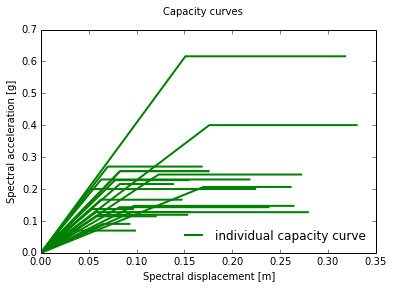

In [1]:
from rmtk.vulnerability.common import utils
%matplotlib inline 

capacity_curves_file = '../../../../../../rmtk_data/capacity_curves_Sa-Sd.csv'
capacity_curves = utils.read_capacity_curves(capacity_curves_file)
utils.plot_capacity_curves(capacity_curves)

## Load ground motion records

In [2]:
gmrs_folder = '../../../../../../rmtk_data/accelerograms'
gmrs = utils.read_gmrs(gmrs_folder)
minT = 0.0
maxT = 2
#utils.plot_response_spectra(gmrs,minT,maxT)

##Assess nonlinear structural response


In [3]:
import capacitySpectrumMethod

damage_model = utils.read_damage_model('../../../../../../rmtk_data/damage_model.csv')
print damage_model
damping_model = 'Priesley_et_al2007_frames'
damping = 0.05
#PDM, Sds = capacitySpectrumMethod.calculate_fragility(capacity_curves,gmrs,damage_model,damping_model,damping)

{'damage_states': ['Slight', 'Moderate', 'Extensive', 'Collapse'], 'cov': [0.0, 0.0, 0.0, 0.0], 'type_criteria': 'capacity curve dependent', 'type_damage_state': ['Sdy', '3 Sdy 1 Sdu', '1 Sdy 1 Sdu', 'Sdu'], 'distribution': ['normal', 'normal', 'normal', 'normal'], 'mean': [0.5, '0', '0', '0']}


##Calculate fragiity function

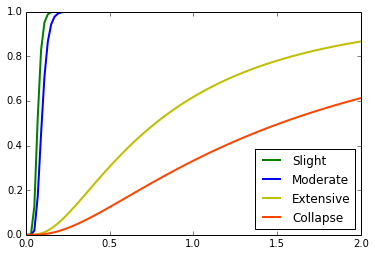

In [6]:
T = 0.3
regression_method = 'least squares'
PDM = 0
no_samples = 100
size_sample = 60
output_type = 'nrml'
taxonomy = 'RC'
minIML = 0.01
maxIML = 1


fragility_model = utils.calculate_mean_fragility(gmrs,PDM,T,damping,'Sa',damage_model,regression_method)
utils.plot_fragility_model(fragility_model,0.01,2)
utils.plot_fragility_stats(fragility_statistics,minIML,maxIML)

utils.save_mean_fragility(taxonomy,fragility_model,minIML,maxIML,output_type)

##Calculate Vulnerability function

In [5]:
cons_model_file = '../../../../../../rmtk_data/cons_model.csv'
cons_model = utils.read_consequence_model(cons_model_file)
imls = [0.1,0.2,0.3,0.4,0.5,0.6,0.8,0.9,1.0]
type_distribution = 'PMF'
output_type = 'csv'
vulnerability_model = utils.convert_fragility_vulnerability(fragility_model,cons_model,imls,type_distribution)
utils.save_vulnerability(taxonomy,vulnerability_model,output_type)

In [6]:
print vulnerability_model

{'probabilities': array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]), 'distribution': 'PMF', 'loss_ratios': array([ 0.        ,  0.11111111,  0.22222222,  0.33333333,  0.44444444,
        0.55555556,  0.66666667,  0.77777778,  0.88888889,  1.        ]), 'imls': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 0.9, 1.0], 'IMT': 'Sa(0.3)'}
